# Regression Analysis on Canadian Rental Data

This notebook performs regression analysis to predict housing prices in Canadian cities based on several features. The analysis includes data cleaning, EDA, and multiple regression models including Linear Regression, Ridge, and Lasso.

## Objectives
- **Understand the dataset:** Perform EDA to explore the distribution of features, correlations, and identify any data quality issues.
- **Data Cleaning:** Handle missing values and prepare the dataset for modeling.
- **Modeling:** Apply and evaluate different regression models to predict rental prices.
- **Model Evaluation:** Use metrics like RMSE and R^2 to evaluate model performance and select the best model.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm

sns.set_theme()

In [4]:
# Loading dataset
df = pd.read_csv('./canada_rent.csv')
df.sample(5)

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
4620,569634,Calgary,Alberta,1025 5th Avenue Southwest,51.048654,-114.085101,Long Term,Condo Unit,2200.0,1 Bed,1,704,/ab/calgary/rentals/condo/1-bedroom/downtown/p...,Negotiable,Negotiable,Non-Smoking,True,False
435,343046,Calgary,Alberta,111 25th Ave SW,51.029764,-114.065254,Long Term,Apartment,2023.0,1 Bed,1,754,/ab/calgary/rentals/apartment/1-bedroom/missio...,Unfurnished,July 04,Non-Smoking,True,True
8807,481088,Wetaskiwin,Alberta,5714 47 Street,52.976301,-113.368036,Long Term,Apartment,1175.0,2 Beds,1,970,/ab/wetaskiwin/rentals/apartment/2-bedrooms/no...,Unfurnished,Immediate,Non-Smoking,False,False
704,417846,Calgary,Alberta,919 10 Ave SW,51.043534,-114.082819,Long Term,Apartment,2180.0,1 Bed,1,543,/ab/calgary/rentals/apartment/1-bedroom/downto...,Unfurnished,July 01,Non-Smoking,True,True
3153,571736,Calgary,Alberta,626 14 Ave SW,51.039870,-114.076018,Long Term,Condo Unit,2095.0,1 Bed,1,555,/ab/calgary/rentals/condo/1-bedroom/beltline/f...,Furnished,June 20,Non-Smoking,False,False


In [5]:
# relevant columns I think are necessary to predict housing prices. 
cols_to_use = ['city', 
               'lease_term', 
               'type', 
               'price', 'beds', 'baths', 'sq_feet', 'furnishing'] #  ,'smoking', 'cats', 'dogs'
df = df[cols_to_use]
df.sample(10)

,city,lease_term,type,price,beds,baths,sq_feet,furnishing
2941,Calgary,Long Term,Townhouse,2475.0,3 Beds,2.5,1500,Unfurnished
23751,Montréal,Long Term,Apartment,1590.0,Studio,1,467,Unfurnished
13430,Calgary,Long Term,Condo Unit,2250.0,2 Beds,1,900,Unfurnished
7449,Edmonton,Long Term,Apartment,1549.0,1 Bed,1,734,Unfurnished
5453,Edmonton,Long Term,Townhouse,1545.0,2 Beds,1,1050,Unfurnished
5481,Edmonton,Long Term,Apartment,1270.0,1 Bed,1,645,Unfurnished
6629,Edmonton,Long Term,Apartment,1845.0,2 Beds,1,865,Unfurnished
4605,Calgary,Long Term,Room For Rent,650.0,1 Bed,1,NaN,Furnished
8601,Sherwood Park,Long Term,Apartment,1505.0,1 Bed,1,593,Unfurnished
5657,Edmonton,Long Term,Apartment,1354.0,1 Bed,1,625,Unfurnished


In [6]:
# EDA stuff: Display summary statistics
print(df.sample(2))
print(df.info())
print(df.describe())

           city lease_term        type   price    beds baths sq_feet  \
13340   Calgary  Long Term  Condo Unit  2300.0  2 Beds     1    1100   
23812  Montréal  Long Term   Apartment  2545.0  2 Beds     1     731   

        furnishing  
13340   Negotiable  
23812  Unfurnished  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25771 entries, 0 to 25770
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        25771 non-null  object 
 1   lease_term  25725 non-null  object 
 2   type        25771 non-null  object 
 3   price       25771 non-null  float64
 4   beds        25639 non-null  object 
 5   baths       25637 non-null  object 
 6   sq_feet     21659 non-null  object 
 7   furnishing  25771 non-null  object 
dtypes: float64(1), object(7)
memory usage: 1.6+ MB
None
              price
count  25771.000000
mean    2151.624142
std      972.820941
min        0.000000
25%     1600.000000
50%     2045.000000
75%  

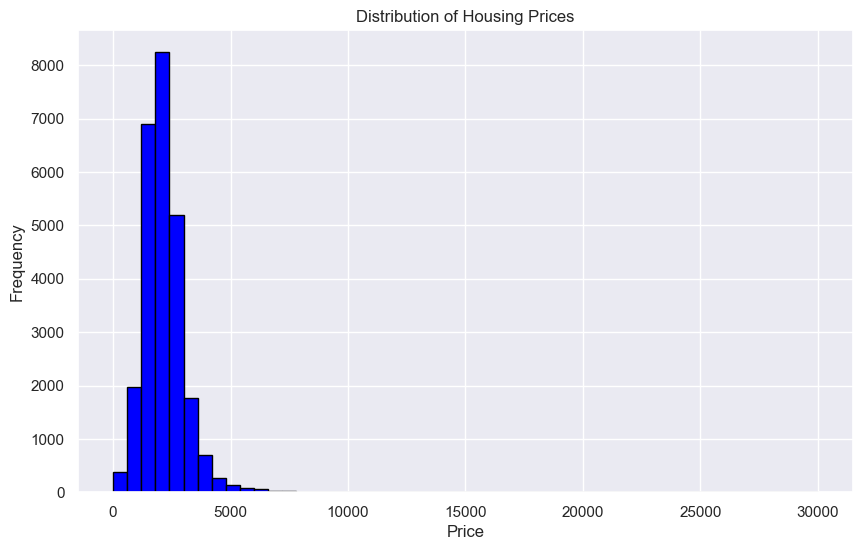

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(df['price'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Housing Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [8]:
# Find NAN values
print(df.isna().sum(),'\n')
df.dropna(inplace=True)
print(df.isna().sum())

city             0
lease_term      46
type             0
price            0
beds           132
baths          134
sq_feet       4112
furnishing       0
dtype: int64 

city          0
lease_term    0
type          0
price         0
beds          0
baths         0
sq_feet       0
furnishing    0
dtype: int64


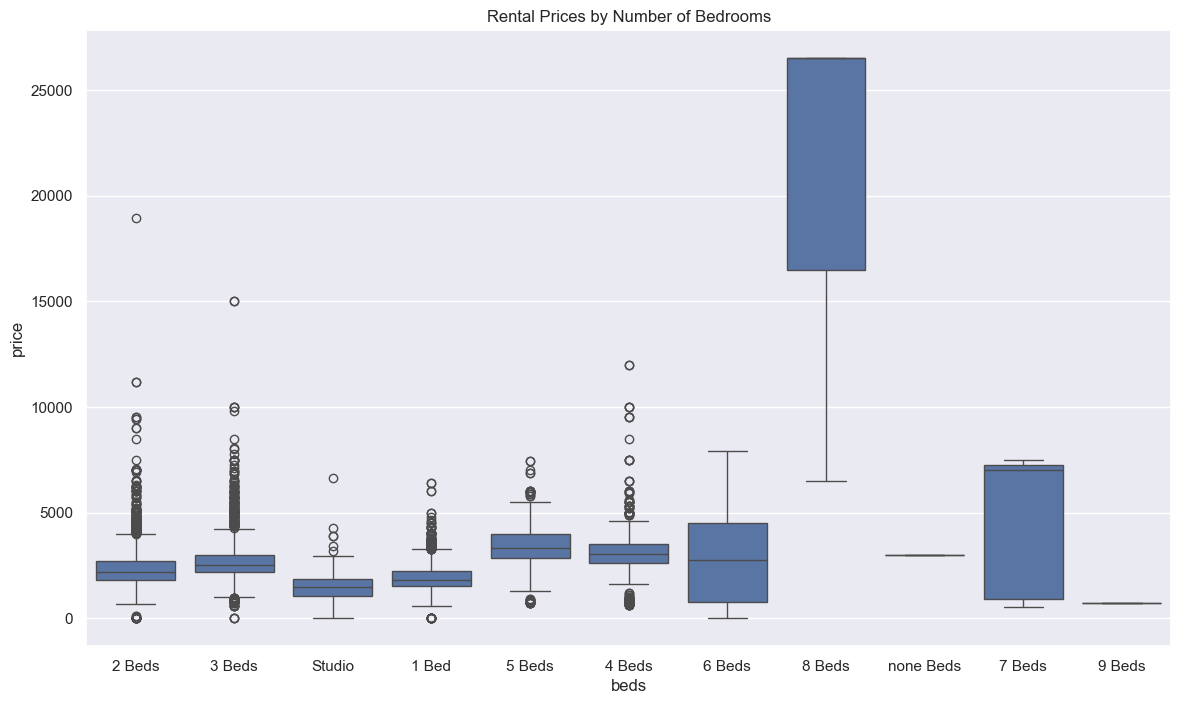

In [9]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='beds', y='price', data=df)
plt.title('Rental Prices by Number of Bedrooms')
plt.show()

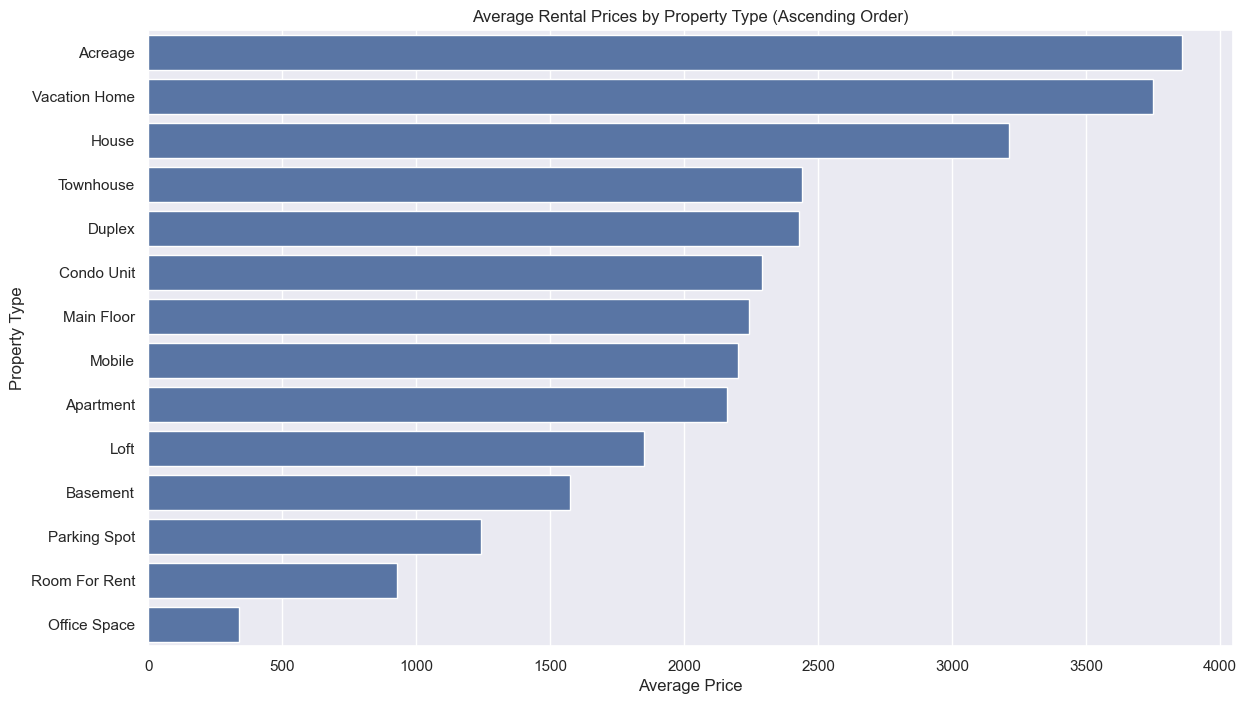

In [10]:
# Calculating average prices by property type
average_prices = df.groupby('type')['price'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(14, 8))
# horizontal bar graph
sns.barplot(x='price', y='type', data=average_prices)  # Note: x and y are swapped for horizontal bars
plt.title('Average Rental Prices by Property Type (Ascending Order)')
plt.xlabel('Average Price')  
plt.ylabel('Property Type')  
plt.show()

# Data Cleaning

In [12]:
# Clean Furnishing column discrepancy
df.loc[df['furnishing'] == 'Unfurnished, Negotiable', 'furnishing'] = 'Negotiable'

# Remove rows where sq_feet is 0
df = df[df['sq_feet'] != 0]

# Clean Baths column
df['baths'] = df['baths'].replace({'none': 0}).astype(float)

# Extract numeric values from sq_feet and handle NaNs
df['sq_feet'] = pd.to_numeric(df['sq_feet'].str.extract(r'(\d+)', expand=False), errors='coerce')
df['sq_feet'] = df['sq_feet'].fillna(df['sq_feet'].median())

# Remove rows where price is 0 or 1
df = df[df['price'] != 0]
df = df[df['price'] != 1]

# Ensure beds column is consistent
df['beds'] = df['beds'].replace({'Studio': '0 Beds'})  # Example of standardizing

In [13]:
df.shape

(21491, 8)

In [14]:
columns_encode = ['city', 'lease_term', 'type', 'beds', 'furnishing'] # encoded
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first') # OneHotEncoder with drop='first' to avoid multicollinearity
encoded_columns = one_hot_encoder.fit_transform(df[columns_encode]) # Encode selected columns

# DataFrame of the encoded columns with appropriate column names
encoded_columns_df = pd.DataFrame(encoded_columns, columns=one_hot_encoder.get_feature_names_out(columns_encode))
encoded_columns_df.index = df.index # Ensure the index of the new DataFrame matches the original df
df = pd.concat([df.drop(columns_encode, axis=1), encoded_columns_df], axis=1) # Drop the original columns and concatenate the encoded columns to the original DataFrame

df.sample(5)

,price,baths,sq_feet,city_Airdrie,city_Ajax,city_Aldersyde,city_Amherstview,city_Ancaster,city_Assiniboia,city_Aurora,...,beds_3 Beds,beds_4 Beds,beds_5 Beds,beds_6 Beds,beds_7 Beds,beds_8 Beds,beds_9 Beds,beds_none Beds,furnishing_Negotiable,furnishing_Unfurnished
18924,1750.0,1.0,730.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5858,1665.0,2.0,826.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19945,2625.0,1.0,548.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6496,2750.0,3.5,2200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10684,3600.0,2.5,2400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [15]:
df.shape

(21491, 278)

## Start defining a Model:

In [17]:
X = df.drop(columns=['price']) # features
y = df['price'] # target

In [18]:
# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [19]:
# Combine training and validation data for final model fitting
X_train_valid = pd.concat([X_train, X_valid], axis=0)  # Use pd.concat to keep DataFrame structure
y_train_valid = np.concatenate((y_train, y_valid), axis=0)

# Standardize
scaler = StandardScaler()
X_train_valid = scaler.fit_transform(X_train_valid)  # Fit on combined DataFrame
X_test = scaler.transform(X_test)  # Transform test data

# Convert back to DataFrame with feature names
X_train_valid = pd.DataFrame(X_train_valid, columns=X_train.columns)  # Use X_train's columns
X_test = pd.DataFrame(X_test, columns=X_train.columns)  # Ensure X_test has the same columns

In [20]:
# Fit the models with cross-validation on the combined training and validation set
ridge_cv = RidgeCV(alphas=[0.1, 1.0, 10.0]).fit(X_train_valid, y_train_valid)
lasso_cv = LassoCV(alphas=[0.1, 1.0, 10.0], max_iter=10000).fit(X_train_valid, y_train_valid)
elastic_cv = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.9], alphas=[0.1, 1.0, 10.0], max_iter=10000, random_state=42).fit(X_train_valid, y_train_valid)

In [21]:
# Get the best alpha values
best_alpha_ridge = ridge_cv.alpha_
best_alpha_lasso = lasso_cv.alpha_

In [22]:
# Predict using the models fitted with CV
y_pred_ridge = ridge_cv.predict(X_test)
y_pred_lasso = lasso_cv.predict(X_test)
y_pred_elastic = elastic_cv.predict(X_test)

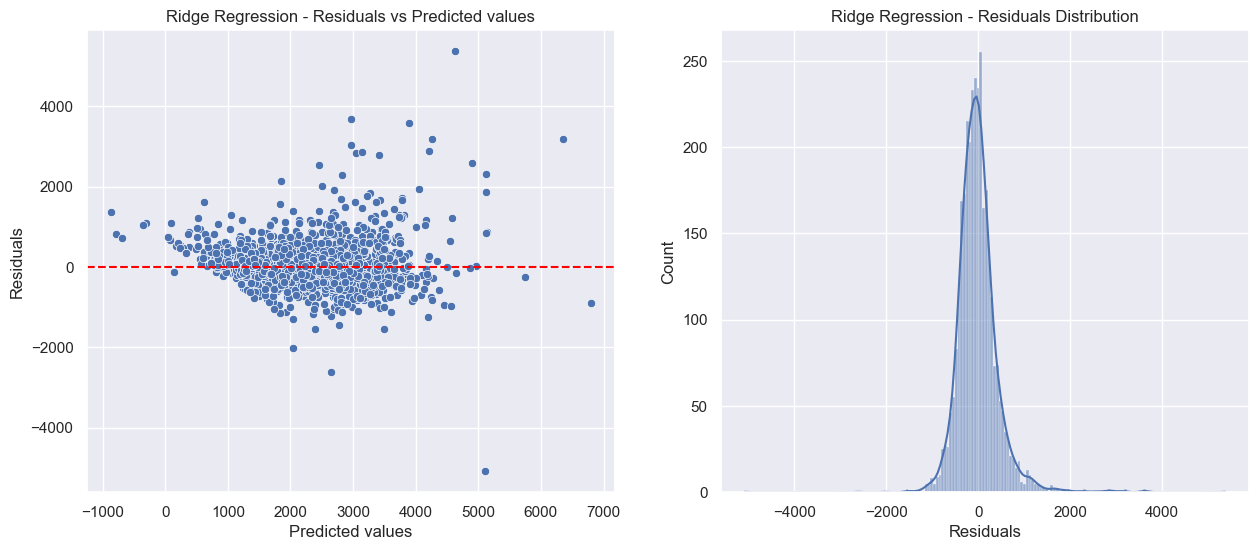

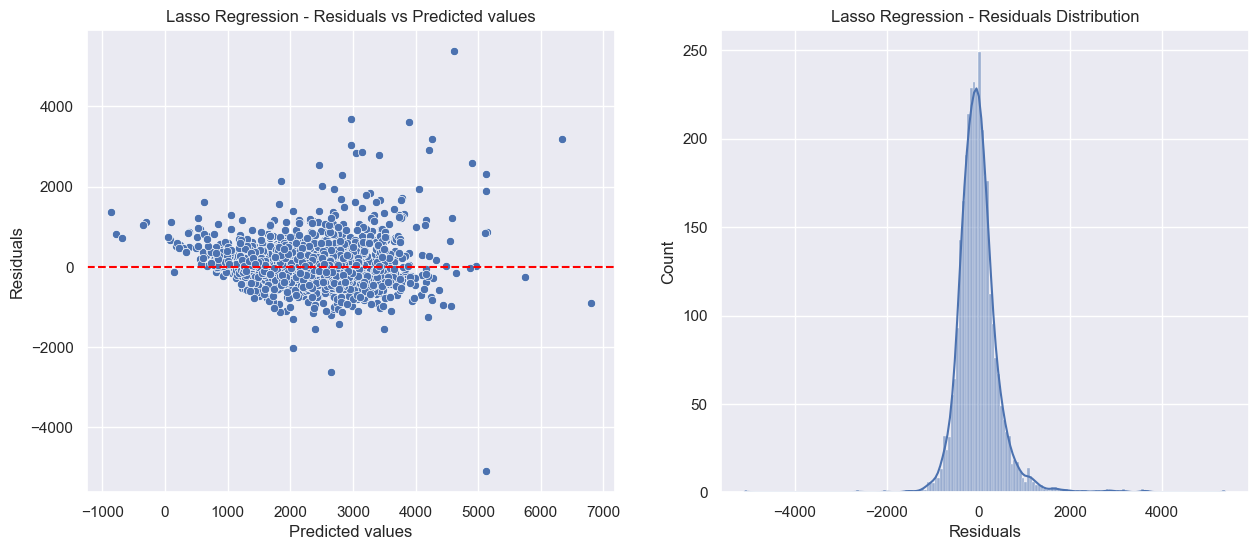

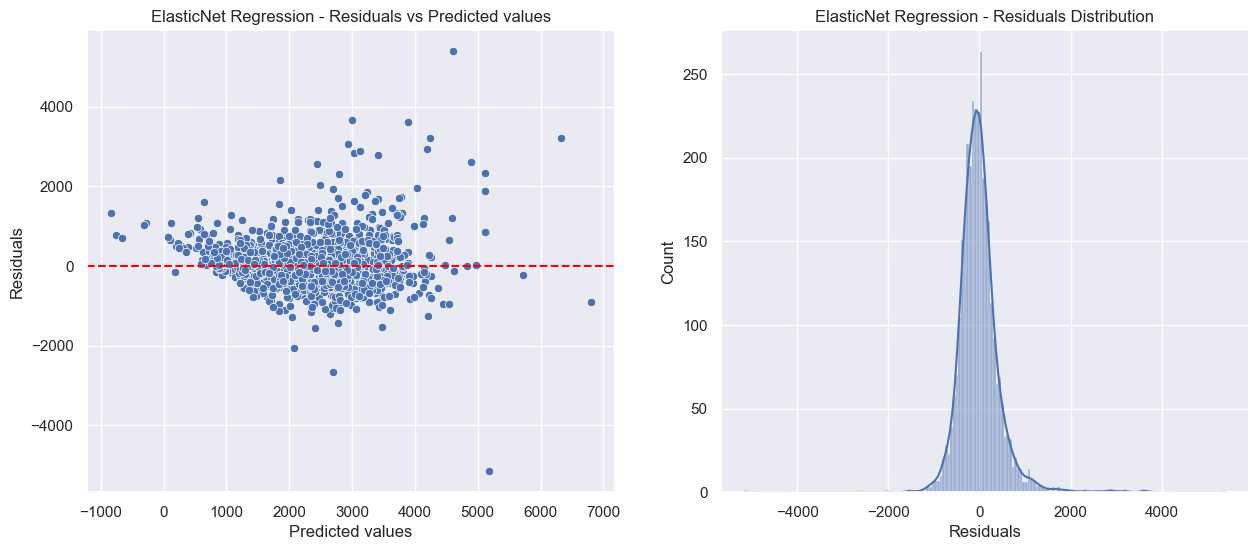

In [23]:
# lets define a function to plot residuals
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred 
    plt.figure(figsize=(15, 6))
    
    # Residuals vs Predicted values
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Residuals vs Predicted values')

    # Histogram residuals
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuals')
    plt.title(f'{model_name} - Residuals Distribution')
    plt.show()

# Plot residuals for both models
plot_residuals(y_test, y_pred_ridge, 'Ridge Regression')
plot_residuals(y_test, y_pred_lasso, 'Lasso Regression')
plot_residuals(y_test, y_pred_elastic, 'ElasticNet Regression')

In [24]:
# Now lets perform polynomial fitting 

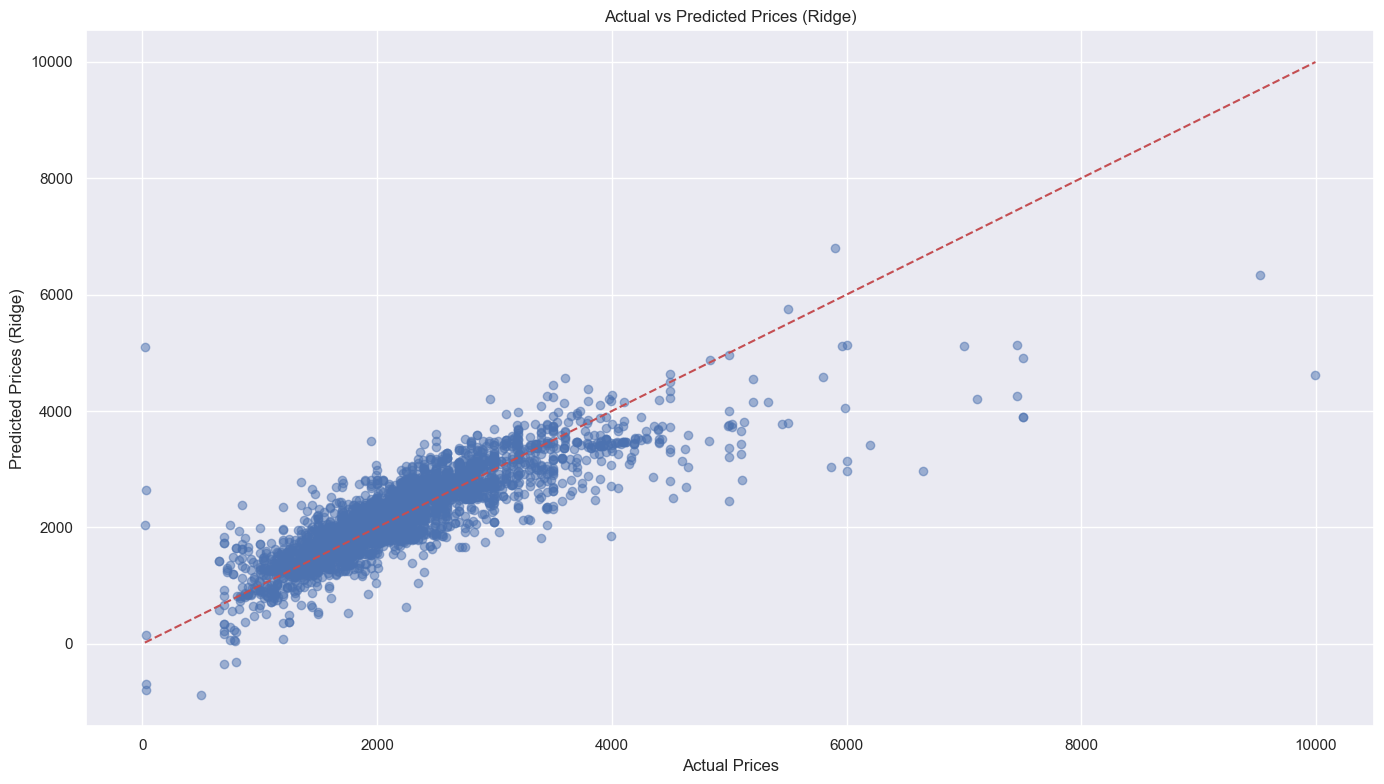

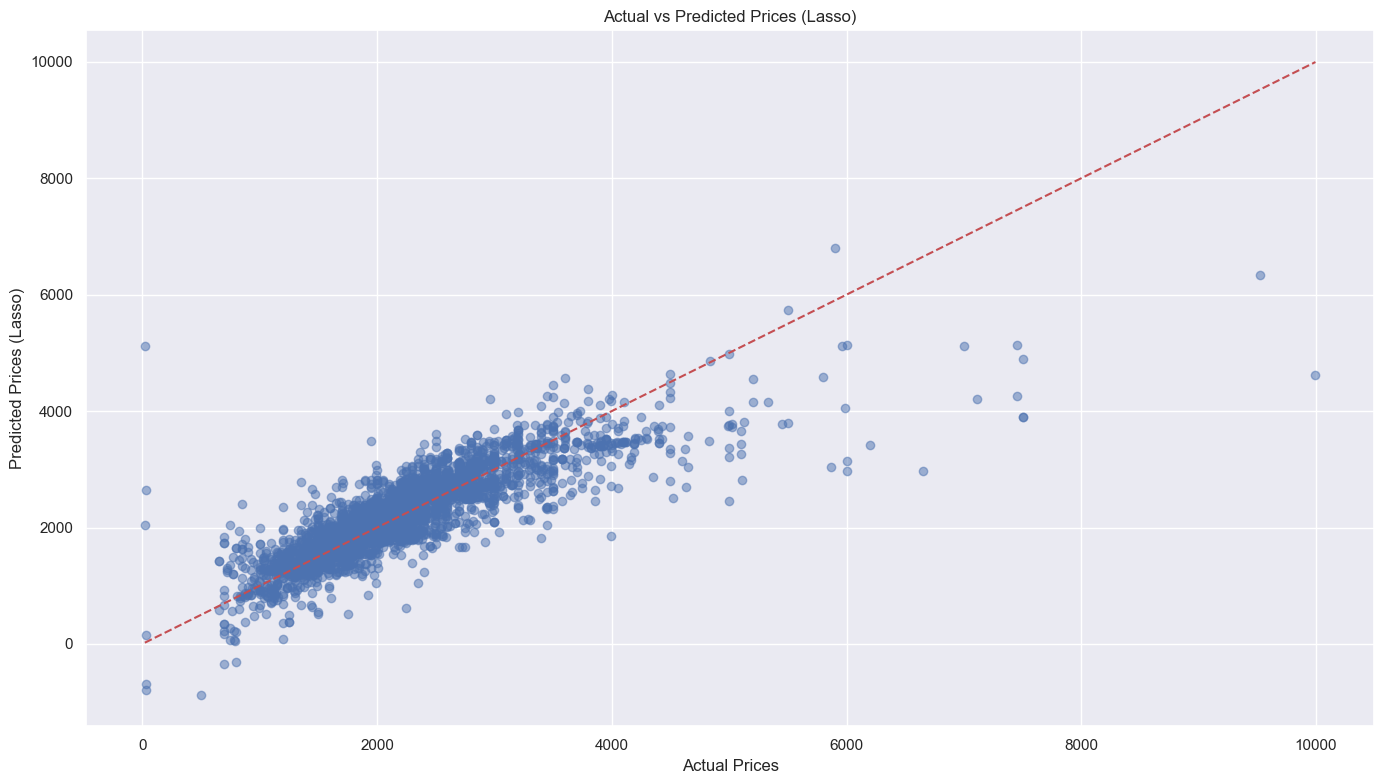

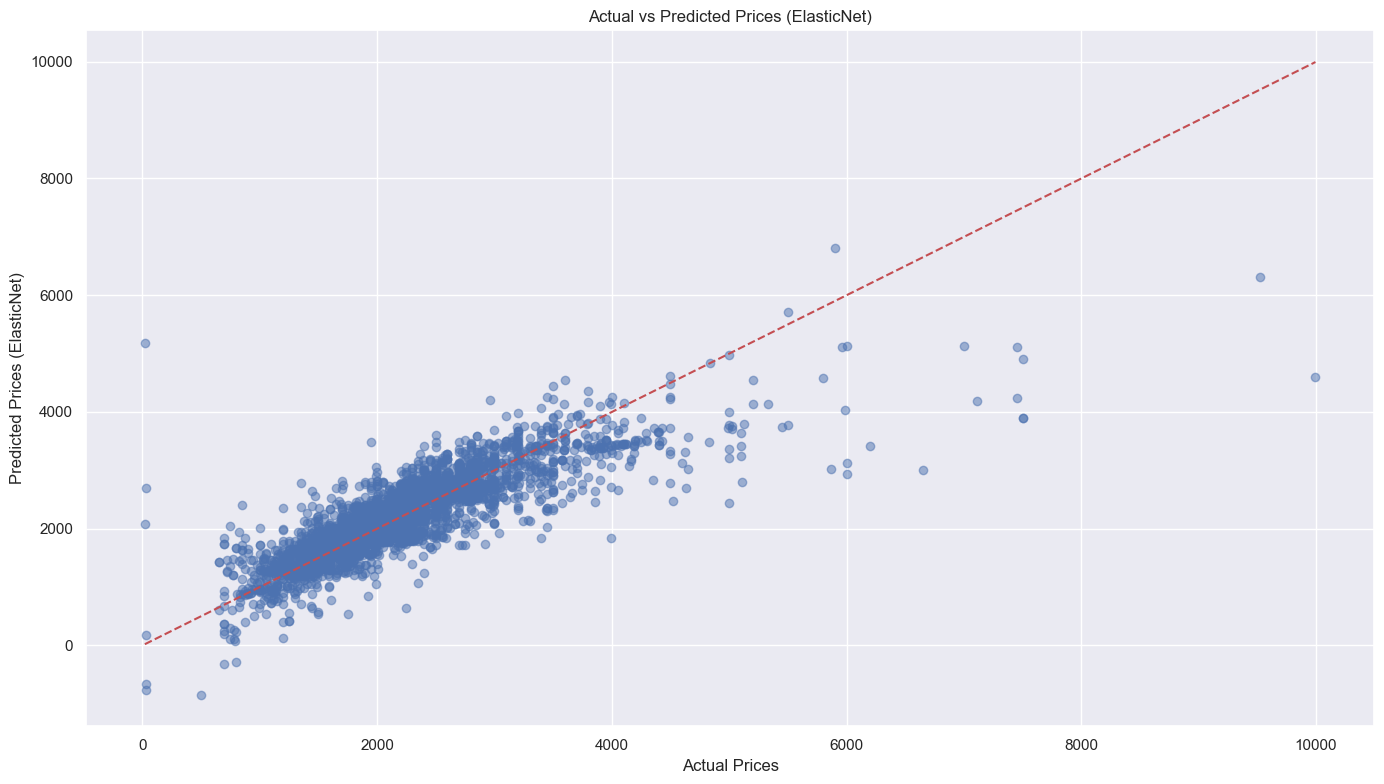

In [25]:
def plot_actual_vs_predicted(y_true, y_pred, model_name):
    plt.figure(figsize=(14, 8))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.xlabel('Actual Prices')
    plt.ylabel(f'Predicted Prices ({model_name})')
    plt.title(f'Actual vs Predicted Prices ({model_name})')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')  # Add a line for reference
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(y_test, y_pred_ridge, 'Ridge')
plot_actual_vs_predicted(y_test, y_pred_lasso, 'Lasso')
plot_actual_vs_predicted(y_test, y_pred_elastic, 'ElasticNet')

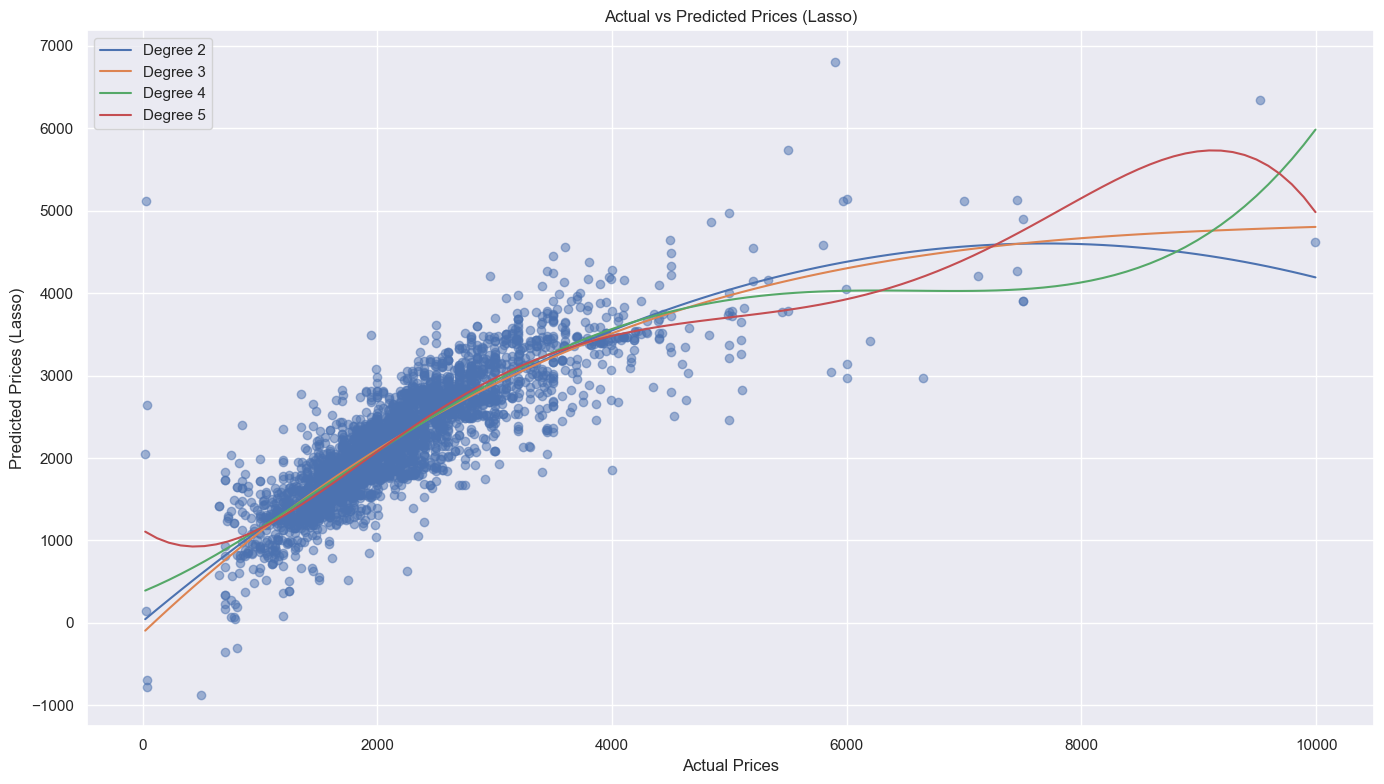

In [26]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(14, 8))
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices (Lasso)')
plt.title('Actual vs Predicted Prices (Lasso)')

# Generate and plot polynomial fits for degrees 2 to 5
degrees = range(2, 6)
metrics = []

for degree in degrees:
    coeffs = np.polyfit(y_test, y_pred_lasso, degree)
    poly = np.poly1d(coeffs)
    
    # Plot the polynomial fit
    x_range = np.linspace(min(y_test), max(y_test), 100)
    plt.plot(x_range, poly(x_range), label=f'Degree {degree}')
    
    # Calculate metrics
    y_poly = poly(y_test)
    mse = mean_squared_error(y_test, y_poly)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_poly)
    metrics.append((degree, mse, rmse, mae))

plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# metrics for RidgeCV
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_r2 = r2_score(y_test, y_pred_ridge)

# metrics for LassoCV
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
lasso_r2 = r2_score(y_test, y_pred_lasso)

# metrics for ElasticNetCV
elastic_rmse = np.sqrt(mean_squared_error(y_test, y_pred_elastic))
elastic_mse = mean_squared_error(y_test, y_pred_elastic)
elastic_r2 = r2_score(y_test, y_pred_elastic)

# Print metrics for RidgeCV
print("Ridge Regression Metrics:")
print(f"RMSE: {ridge_rmse}")
print(f"MSE: {ridge_mse}")
print(f"R^2: {ridge_r2}\n")

# Print metrics for LassoCV
print("Lasso Regression Metrics:")
print(f"RMSE: {lasso_rmse}")
print(f"MSE: {lasso_mse}")
print(f"R^2: {lasso_r2}\n")

# Print metrics for ElasticNetCV
print("ElasticNet Regression Metrics:")
print(f"RMSE: {elastic_rmse}")
print(f"MSE: {elastic_mse}")
print(f"R^2: {elastic_r2}")

Ridge Regression Metrics:
RMSE: 460.42505202191785
MSE: 211991.22852938576
R^2: 0.6980992524119944

Lasso Regression Metrics:
RMSE: 460.4619727653845
MSE: 212025.22836298967
R^2: 0.698050832601165

ElasticNet Regression Metrics:
RMSE: 461.1967980533085
MSE: 212702.48653462421
R^2: 0.6970863363352346


Both Ridge and Lasso Regression models perform similarly, slight differences in RMSE and MSE.
ElasticNet shows lower performance compared to Ridge and Lasso,
Lasso Regression may be preferred for simplicity, can reduce model complexity by effectively selecting most relevant features, 
Ridge Regression maintains all features but reduces their impact via regularization.

In [29]:
# Find best degree based on MSE
best_degree, best_mse, best_rmse, best_mae = min(metrics, key=lambda x: x[1])

print(f'The best polynomial degree is: {best_degree}')
print(f'Best MSE: {best_mse:.2f}')
print(f'Best RMSE: {best_rmse:.2f}')
print(f'Best MAE: {best_mae:.2f}')

The best polynomial degree is: 2
Best MSE: 71906.65
Best RMSE: 268.15
Best MAE: 129.71


In [30]:
# An RMSE of 268.15 tells me that on average the predictions are off approximately $268 from the actual rental prices. Which is super!
# The MAE (Mean Absolute Error) of 129.71 indicates that on average the prediction errors are roughly $129.
# The polynomial regression with degree 2 provided the best balance between the models complexity and prediction accuracy. 
# It captured non-linear relationships in the data without overfitting.

In [31]:
poly_model = np.poly1d(np.polyfit(y_test, y_pred_lasso, 2)) # best degree found is degree = 2
y_pred_poly = poly_model(y_test) # Make predictions using polynomial model
comparison_df = pd.DataFrame({'True Value': y_test, 'Predicted Value': y_pred_poly}) # DataFrame for comparison

print(comparison_df.head())

       True Value  Predicted Value
4778       1800.0      1913.175412
1701       1650.0      1774.501335
5805       1695.0      1816.469654
24264      1770.0      1885.719527
273        2351.0      2392.644513


In [32]:
# These prediction observations tell me that the model is performing relatively well,
# The polynomial degree of 2 is most effective in capturing the underlying patterns in the data of the list of degrees 1 through 5.

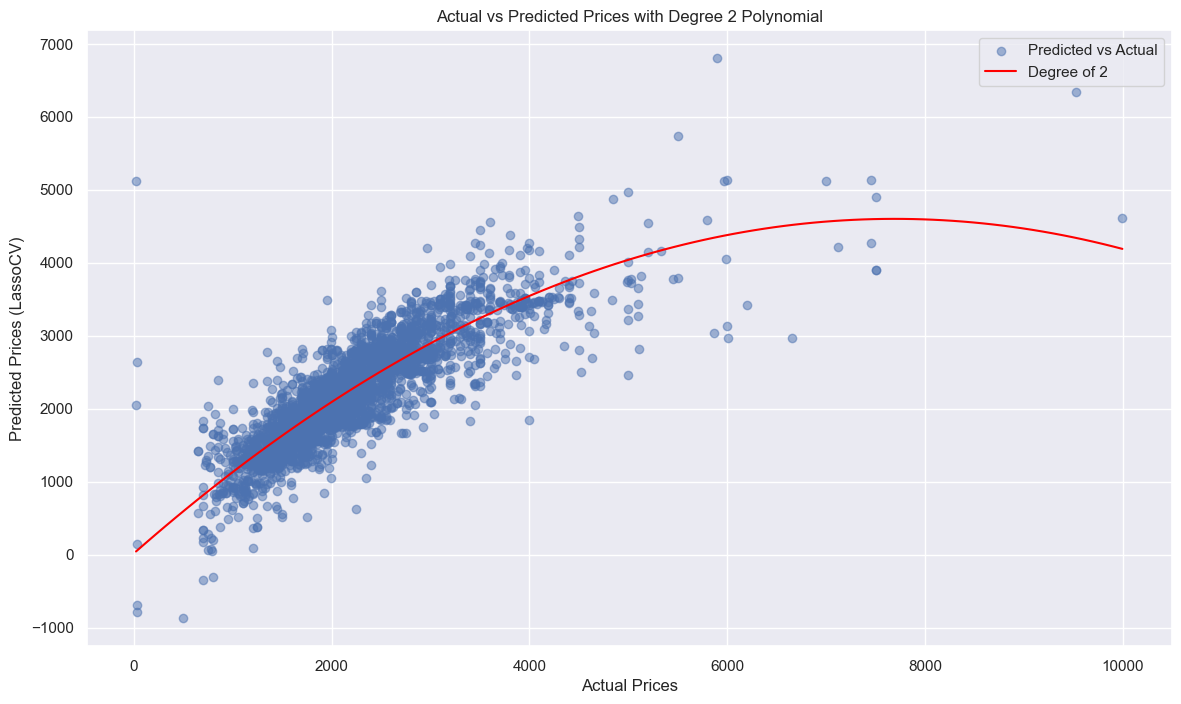

In [63]:
# Scatter plot of actual vs predicted prices
plt.figure(figsize=(14, 8))
plt.scatter(y_test, y_pred_lasso, alpha=0.5, label='Predicted vs Actual')

# Degree of 2 polynomial
poly = np.poly1d(np.polyfit(y_test, y_pred_lasso, 2))
x_range = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x_range, poly(x_range), color='red', label='Degree of 2')

plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices (LassoCV)')
plt.title('Actual vs Predicted Prices with Degree 2 Polynomial')
plt.legend()
plt.show()

# The End!